# Novel Inertia Based Human Pose Estimation Using CNN

In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
from utils import *

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
#Import data from MatLab SimScape Multibody Simulator

#data comes from two files
#1) n trajectories in xyz space, each length m
traj = np.loadtxt(open("simulation/data/traj.txt", "rb"), delimiter=",")
trajPts = np.shape(traj)[0] #points per trajectory
numTraj = np.shape(traj)[1]//3 #number of total trajectories
#traj needs to be reshaped to a 3d numpy array
#as is traj[n] shows [x,y,z,x,y,z...]


#2) 7 joint angles at the end of the sequence
jointPos = np.loadtxt(open("simulation/data/jointPos.txt", "rb"), delimiter=",")

# print(traj[-1])
# print(jointPos[0])



In [3]:
#reshape traj data into 3d numpy array
# print(np.shape(traj)) #(10,30) -> should be (10,3,10)
t = np.zeros([trajPts,3,numTraj])
for j in range(np.shape(traj)[0]):
    for i in range(np.shape(traj)[1]//3):
        t[j,:,i] = traj[j,3*i:3*(i+1)]
# print(t[:,:,0]) #same as in MatLab
print(np.shape(t))
#swap axis so batch size is first axis (for TF)
t = np.swapaxes(t,0,2)
print(np.shape(t)) #[numTraj, xyz, trajPts]
#swap axis again so that conv1D moves on time and not xyz
t = np.swapaxes(t,1,2)
print(np.shape(t))

(10, 3, 10000)
(10000, 3, 10)
(10000, 10, 3)


In [4]:
#Convert data from numpy to tensors

#shuffle data

In [110]:
from network import Net

np.random.seed(1337)

#convert data from numpy to tensors
x_train = tf.convert_to_tensor(t,np.float32)
y_train = tf.convert_to_tensor(jointPos,np.float32)

#TODO -> shuffle data


# print(tf.shape(x_train))
# print(x_train[0,:,1])

In [115]:
model = Net() #starting out with basic linear feedforward network (CNN wrote for CIFR-10 does not work with 2D data)

runLen = 300    

def scheduler(epoch, lr):
    part1 = runLen//3
    part2 = 2*runLen//3
    
    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.001
        return lr
    if epoch >= part2:
        lr = 0.0001
        return lr


model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],)

summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#Train Model
trace = model.fit(x=x_train, y=y_train, batch_size=256, epochs=runLen, verbose=1, 
                  validation_split=0.1, callbacks = [callback], shuffle=True)

Model: "functional_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 10, 3)]      0                                            
__________________________________________________________________________________________________
batch_normalization_217 (BatchN (None, 10, 3)        12          input_33[0][0]                   
__________________________________________________________________________________________________
conv1d_133 (Conv1D)             (None, 8, 16)        160         batch_normalization_217[0][0]    
__________________________________________________________________________________________________
conv1d_134 (Conv1D)             (None, 8, 16)        784         conv1d_133[0][0]                 
______________________________________________________________________________________

36/36 [==============================] - 5s 128ms/step - loss: 1159.3547 - mean_squared_error: 1159.3547 - val_loss: 687.9275 - val_mean_squared_error: 687.9275
Epoch 2/300
36/36 [==============================] - 0s 9ms/step - loss: 710.2150 - mean_squared_error: 710.2150 - val_loss: 692.9536 - val_mean_squared_error: 692.9536
Epoch 3/300
36/36 [==============================] - 0s 9ms/step - loss: 683.3289 - mean_squared_error: 683.3289 - val_loss: 678.6530 - val_mean_squared_error: 678.6530
Epoch 4/300
36/36 [==============================] - 0s 9ms/step - loss: 646.4471 - mean_squared_error: 646.4471 - val_loss: 681.7542 - val_mean_squared_error: 681.7542
Epoch 5/300
36/36 [==============================] - 0s 9ms/step - loss: 632.3485 - mean_squared_error: 632.3485 - val_loss: 691.3320 - val_mean_squared_error: 691.3320
Epoch 6/300
36/36 [==============================] - 0s 9ms/step - loss: 595.0110 - mean_squared_error: 595.0110 - val_loss: 791.3743 - val_mean_squared_error: 791

36/36 [==============================] - 0s 9ms/step - loss: 449.5471 - mean_squared_error: 449.5471 - val_loss: 489.8433 - val_mean_squared_error: 489.8433
Epoch 50/300
36/36 [==============================] - 0s 9ms/step - loss: 458.4881 - mean_squared_error: 458.4881 - val_loss: 535.0635 - val_mean_squared_error: 535.0635
Epoch 51/300
36/36 [==============================] - 0s 9ms/step - loss: 487.7767 - mean_squared_error: 487.7767 - val_loss: 553.8007 - val_mean_squared_error: 553.8007
Epoch 52/300
36/36 [==============================] - 0s 9ms/step - loss: 453.5797 - mean_squared_error: 453.5797 - val_loss: 538.3627 - val_mean_squared_error: 538.3627
Epoch 53/300
36/36 [==============================] - 0s 9ms/step - loss: 448.0051 - mean_squared_error: 448.0051 - val_loss: 498.7173 - val_mean_squared_error: 498.7173
Epoch 54/300
36/36 [==============================] - 0s 9ms/step - loss: 435.2909 - mean_squared_error: 435.2909 - val_loss: 491.8032 - val_mean_squared_error: 49

36/36 [==============================] - 0s 9ms/step - loss: 315.6080 - mean_squared_error: 315.6080 - val_loss: 434.0296 - val_mean_squared_error: 434.0296
Epoch 98/300
36/36 [==============================] - 0s 9ms/step - loss: 323.6033 - mean_squared_error: 323.6033 - val_loss: 451.9925 - val_mean_squared_error: 451.9925
Epoch 99/300
36/36 [==============================] - 0s 9ms/step - loss: 314.3088 - mean_squared_error: 314.3088 - val_loss: 447.3791 - val_mean_squared_error: 447.3791
Epoch 100/300
36/36 [==============================] - 0s 9ms/step - loss: 310.0807 - mean_squared_error: 310.0807 - val_loss: 423.7639 - val_mean_squared_error: 423.7639
Epoch 101/300
36/36 [==============================] - 0s 9ms/step - loss: 282.2828 - mean_squared_error: 282.2828 - val_loss: 387.3936 - val_mean_squared_error: 387.3936
Epoch 102/300
36/36 [==============================] - 0s 9ms/step - loss: 265.8867 - mean_squared_error: 265.8867 - val_loss: 382.0587 - val_mean_squared_error:

Epoch 145/300
36/36 [==============================] - 0s 9ms/step - loss: 217.7297 - mean_squared_error: 217.7297 - val_loss: 399.7113 - val_mean_squared_error: 399.7113
Epoch 146/300
36/36 [==============================] - 0s 9ms/step - loss: 214.3276 - mean_squared_error: 214.3276 - val_loss: 413.5053 - val_mean_squared_error: 413.5053
Epoch 147/300
36/36 [==============================] - 0s 9ms/step - loss: 213.6415 - mean_squared_error: 213.6415 - val_loss: 400.3871 - val_mean_squared_error: 400.3871
Epoch 148/300
36/36 [==============================] - 0s 9ms/step - loss: 216.0258 - mean_squared_error: 216.0258 - val_loss: 400.3776 - val_mean_squared_error: 400.3776
Epoch 149/300
36/36 [==============================] - 0s 9ms/step - loss: 214.0260 - mean_squared_error: 214.0260 - val_loss: 399.4709 - val_mean_squared_error: 399.4709
Epoch 150/300
36/36 [==============================] - 0s 9ms/step - loss: 210.2223 - mean_squared_error: 210.2223 - val_loss: 402.0160 - val_mea

Epoch 193/300
36/36 [==============================] - 0s 10ms/step - loss: 176.2850 - mean_squared_error: 176.2850 - val_loss: 430.5193 - val_mean_squared_error: 430.5193
Epoch 194/300
36/36 [==============================] - 0s 9ms/step - loss: 181.6840 - mean_squared_error: 181.6840 - val_loss: 409.7565 - val_mean_squared_error: 409.7565
Epoch 195/300
36/36 [==============================] - 0s 9ms/step - loss: 174.3505 - mean_squared_error: 174.3505 - val_loss: 419.8012 - val_mean_squared_error: 419.8012
Epoch 196/300
36/36 [==============================] - 0s 9ms/step - loss: 177.7387 - mean_squared_error: 177.7387 - val_loss: 421.1288 - val_mean_squared_error: 421.1288
Epoch 197/300
36/36 [==============================] - 0s 9ms/step - loss: 177.9478 - mean_squared_error: 177.9478 - val_loss: 416.4756 - val_mean_squared_error: 416.4756
Epoch 198/300
36/36 [==============================] - 0s 9ms/step - loss: 173.5593 - mean_squared_error: 173.5593 - val_loss: 422.5881 - val_me

Epoch 241/300
36/36 [==============================] - 0s 9ms/step - loss: 157.3931 - mean_squared_error: 157.3931 - val_loss: 422.9761 - val_mean_squared_error: 422.9761
Epoch 242/300
36/36 [==============================] - 0s 9ms/step - loss: 153.9308 - mean_squared_error: 153.9308 - val_loss: 421.4151 - val_mean_squared_error: 421.4151
Epoch 243/300
36/36 [==============================] - 0s 9ms/step - loss: 158.9649 - mean_squared_error: 158.9649 - val_loss: 422.9309 - val_mean_squared_error: 422.9309
Epoch 244/300
36/36 [==============================] - 0s 9ms/step - loss: 154.7137 - mean_squared_error: 154.7137 - val_loss: 421.5654 - val_mean_squared_error: 421.5654
Epoch 245/300
36/36 [==============================] - 0s 9ms/step - loss: 154.4269 - mean_squared_error: 154.4269 - val_loss: 419.7113 - val_mean_squared_error: 419.7113
Epoch 246/300
36/36 [==============================] - 0s 9ms/step - loss: 155.1139 - mean_squared_error: 155.1139 - val_loss: 421.3958 - val_mea

Epoch 289/300
36/36 [==============================] - 0s 9ms/step - loss: 156.5411 - mean_squared_error: 156.5411 - val_loss: 424.2697 - val_mean_squared_error: 424.2697
Epoch 290/300
36/36 [==============================] - 0s 9ms/step - loss: 149.7159 - mean_squared_error: 149.7159 - val_loss: 424.6783 - val_mean_squared_error: 424.6783
Epoch 291/300
36/36 [==============================] - 0s 9ms/step - loss: 148.2362 - mean_squared_error: 148.2362 - val_loss: 423.6150 - val_mean_squared_error: 423.6150
Epoch 292/300
36/36 [==============================] - 0s 9ms/step - loss: 150.5630 - mean_squared_error: 150.5630 - val_loss: 424.1024 - val_mean_squared_error: 424.1024
Epoch 293/300
36/36 [==============================] - 0s 9ms/step - loss: 150.9664 - mean_squared_error: 150.9664 - val_loss: 425.1926 - val_mean_squared_error: 425.1926
Epoch 294/300
36/36 [==============================] - 0s 10ms/step - loss: 149.4367 - mean_squared_error: 149.4367 - val_loss: 424.8860 - val_me

(10.0, 1000.0)

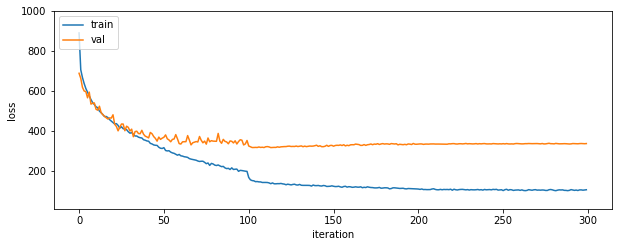

In [112]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(10,1000)

In [114]:
#test model
prediction = model.predict(x_train[-100:-1])
# print(prediction)
actual = y_train[-100:-1]
# print(actual)

error = (actual - prediction)
# print(np.floor(error))

#average error for estimates for each joint
avg = np.average(abs(error),axis=0)
print("average error = ", avg)

#range for each joint:
ranges = [50, 60, 67.5, 110, 120, 360, 130] #TODO -> these are not correct
rel_error = avg/ranges
print("error as frac of joint range = ", np.floor(rel_error*100)) #1 is full range of joint
print("total error = ",sum(rel_error))
#current best is: 0.657 @ [ 9.  8.  3. 15. 11.  4. 12.]

print(prediction[10])
print(actual[10])

average error =  [ 4.75264    4.761795   2.7350328 18.05513   17.606153  19.023626
 17.354607 ]
error as frac of joint range =  [ 9.  7.  4. 16. 14.  5. 13.]
total error =  0.7121309223041667
[-4.4252667e-01 -3.7822202e-02 -5.9545517e-02  8.1271057e+00
  2.7985125e+01  7.1365776e+01 -1.3169701e+01]
tf.Tensor([-1.7404 -1.4911 -3.6938 -2.0154  8.4083 81.116  -4.728 ], shape=(7,), dtype=float32)


In [100]:
model.save("trajectory_cls.kmod")

INFO:tensorflow:Assets written to: trajectory_cls.kmod\assets


In [97]:
#proof my model is doing better than completely random guessing

np.random.seed(None)

# print(actual)
# print(tf.shape(actual)) #[99 7]
B = tf.random.uniform([99,7])

# B = tf.ones([99,7])
B = B *tf.constant([25., 30., 33.75, 55. , 60., 180., 65.]) + tf.constant([0., 0., 26.25, -35., 30., 0., -65.])

# print(tf.shape(B))
# print(tf.shape(actual))

fake_error = (actual - B)
# print(fake_error)

fake_avg = tf.math.reduce_mean(tf.math.abs(fake_error), axis=0)
print(fake_avg)

print(fake_avg/ranges)

#NOTE: these are not all the same becuase the starting ranges for joint positions do NOT fall in the middle of all
#      possible positions for each joint

tf.Tensor(
[13.420133  15.9285145 44.008556  37.255108  37.611813  74.6475
 38.68154  ], shape=(7,), dtype=float32)
tf.Tensor(
[0.26840267 0.26547524 0.6519786  0.3386828  0.31343177 0.20735416
 0.29755032], shape=(7,), dtype=float32)
